# Datenvorbereitung
Zunächst werden für alle gewünschten Einflussfaktoren die Daten beschafft und in ein CSV-Format mit lat/lon oder GeoJSON-Geoemtry gebracht, sodass zu allen Adressen die gewünschten Eigenschaften vorliegen.

In [10]:
import helper
import pandas as pd
from shapely.geometry import Point
from helper import load_geocsv, s
from shapely.geometry import box

EPSG_4326 = "EPSG:4326"

# BBOX für Brandenburg an der Havel
CITY_BOUNDING_BOX = box(12.3120236786, 52.2938432979, 12.7562682548, 52.5594777244)

#  Stadtzentrum für Brandenburg an der Havel
CITY_CENTER = (52.4116351153561, 12.556331280534392)

## Adressen einlesen
Alle Adressen des Zielgebiets als CSV in einen GeoDataFrame einlesen.

In [11]:
gdf_main = load_geocsv("out/adressen_mit_zentrum_routen.csv")

## Ortsteile der Stadt visualisieren und im Datensatz ergänzen

In [12]:
import json
import folium
import geopandas as gpd

# Datei laden
with open("data/ortsteile_brandenburg.json", "r", encoding="utf-8") as f:
    raw = json.load(f)

# FeatureCollection extrahieren
features = raw["features"]
gdf_ortsteile = gpd.GeoDataFrame.from_features(features)
gdf_ortsteile.set_crs(EPSG_4326, inplace=True)
gdf_ortsteile = gdf_ortsteile.clip(CITY_BOUNDING_BOX)

# Karte zentrieren
m = folium.Map(location=CITY_CENTER, zoom_start=12, tiles="cartodbpositron")

# Tooltip konfigurieren
tooltip_fields = ["otl_name"]
tooltip = folium.GeoJsonTooltip(
    fields=tooltip_fields,
    aliases=["Ortsteil"],
    localize=True,
    sticky=True
)

# GeoJSON mit Tooltip zur Karte hinzufügen
folium.GeoJson(
    gdf_ortsteile,
    name="Ortsteile",
    tooltip=tooltip
).add_to(m)

assert gdf_main.crs.to_epsg() == 4326
assert gdf_ortsteile.crs.to_epsg() == 4326

gdf_main = gpd.sjoin(gdf_main, gdf_ortsteile[["geometry", "otl_name"]], how="left", predicate="within")
gdf_main = gdf_main.rename(columns={"otl_name": "ortsteil"})
gdf_main = gdf_main.drop(columns=["index_right"], errors="ignore")

# Drop rows with NaN lat/lon
gdf_main = gdf_main.dropna(subset=["lat"])

# Mögliche Erweiterung: Ergänzung einer Spalte "stadtteil" für spätere Validierung und auch Visualisierung
# Adressen im Zentrum haben korrekterweise keinen Ortsteil

# Karte anzeigen
m


## Explorative Datenanalyse

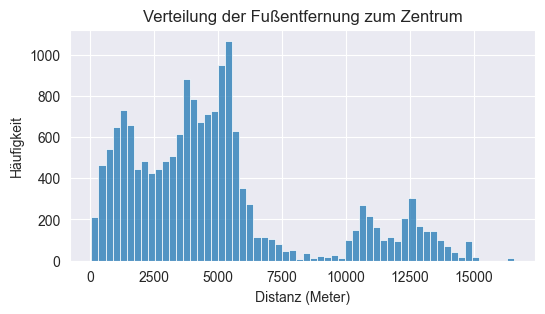

(16905, 10)
Index(['Straßenname', 'Hsnr', 'HsnrZus', 'center_distance_m', 'lat', 'lon',
       'geometry', 'Adresse_merge', 'ortsteil', 'center_route'],
      dtype='object')


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns           # nur für schönere Plots
from helper import load_geocsv, make_merge_addr

# Eindeutigen Merge-baren String aus Adresse erzeugen
gdf_main["Adresse_merge"] = gdf_main.apply(make_merge_addr, axis=1)

gdf_main = gdf_main.rename(columns={"geojson": "center_route",
                                    "distance_m" : "center_distance_m"})

# Relevante Spalten auswählen
gdf_main = gdf_main[["Straßenname", "Hsnr", "HsnrZus",
         "center_distance_m", "lat", "lon", "geometry", "Adresse_merge", "ortsteil", "center_route"]]

# Histogramm der Distanzen zum Zentrum
plt.figure(figsize=(6,3))
sns.histplot(gdf_main["center_distance_m"], bins=60, kde=False)
plt.title("Verteilung der Fußentfernung zum Zentrum")
plt.xlabel("Distanz (Meter)")
plt.ylabel("Häufigkeit")
plt.show()
print(gdf_main.shape)
print(gdf_main.columns)

## Daten bereinigen

In [14]:
print(gdf_main.shape)
# Dubletten aus Adressen entfernen
dups = gdf_main["Adresse_merge"].value_counts()
dups = dups[dups > 1]
print(f"{len(dups)} doppelte Adressen gefunden")
print(dups.head())

# Ersten Treffer behalten
gdf_main = gdf_main.sort_values("Adresse_merge").drop_duplicates("Adresse_merge", keep="first")
print(gdf_main.shape)


(16905, 10)
1 doppelte Adressen gefunden
Adresse_merge
seestraße 4    2
Name: count, dtype: int64
(16904, 10)


## Einzelhandel
Separates Skript ```einzelhandel-adreessen.py``` ausfühen, um Datei "adressen_mit_einzelhandel.csv" zu erzeugen.
Durch fußläufiges Routing berechnete Faktoren:
- Anzahl von Einkaufsmöglichkeiten im Umkreis von 500 m
- Anzahl von Einkaufsmöglichkeiten im Umkreis von 800 m
- Geringste Distanz zum nächsten Einzelhandel

In [15]:
import seaborn as sns, matplotlib.pyplot as plt

# Lade vorberechnete Einzelhandel-Faktoren
gdf_retail = load_geocsv("out/adressen_mit_einzelhandel.csv")

# Merge mit Haupt-GDF
gdf_retail["Adresse_merge"] = gdf_retail.apply(make_merge_addr, axis=1)
gdf_retail = gdf_retail.sort_values("Adresse_merge").drop_duplicates("Adresse_merge", keep="first")

dups = gdf_retail["Adresse_merge"].value_counts()
print(dups[dups > 1])

einzelhandel_attribute = ["shop_min_distance_m", "shops_500m_count", "shops_800m_count"]

gdf_main = pd.merge(
    gdf_main,
    gdf_retail[["Adresse_merge"] + einzelhandel_attribute],
    on="Adresse_merge",
    how="left",
    validate="one_to_many"
)
print(gdf_main.shape)
print(gdf_main[["Adresse_merge", "shop_min_distance_m"]].head())

print(gdf_main.shape)

# Speicher freigeben
del(gdf_retail)

Series([], Name: count, dtype: int64)
(16904, 13)
  Adresse_merge  shop_min_distance_m
0  abtstraße 20                348.2
1  abtstraße 21                208.1
2   abtstraße 4                316.9
3   abtstraße 5                333.1
4   abtstraße 6                281.6
(16904, 13)


Index(['Straßenname', 'Hsnr', 'HsnrZus', 'center_distance_m', 'lat', 'lon',
       'geometry', 'Adresse_merge', 'ortsteil', 'center_route',
       'shop_min_distance_m', 'shops_500m_count', 'shops_800m_count'],
      dtype='object')


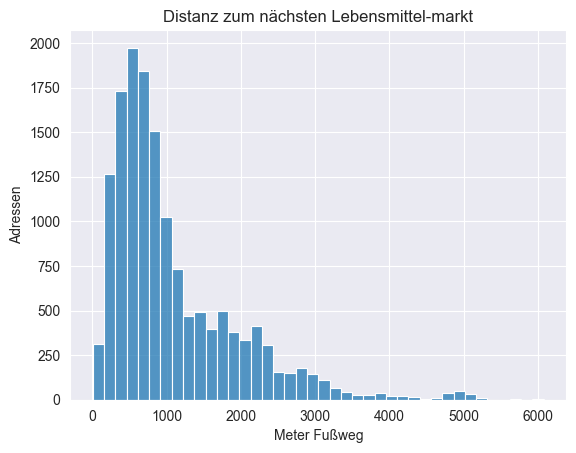

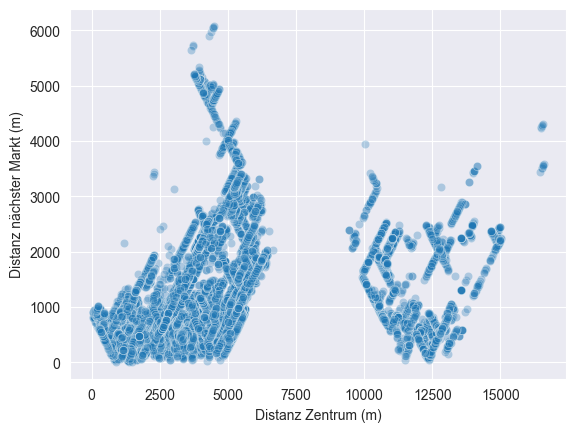

In [16]:
# Verteilung Distanz zum nächsten Markt
print(gdf_main.columns)
sns.histplot(gdf_main["shop_min_distance_m"].dropna(), bins=40, kde=False)
plt.title("Distanz zum nächsten Lebensmittel­markt")
plt.xlabel("Meter Fußweg"); plt.ylabel("Adressen")
plt.show()

# Scatter Zentralität vs. Nahversorgung
sns.scatterplot(x="center_distance_m", y="shop_min_distance_m", data=gdf_main, alpha=.3)
plt.xlabel("Distanz Zentrum (m)"); plt.ylabel("Distanz nächster Markt (m)")
plt.show()

## Lärmbelastung
Siehe ```laerm.ipynb``` zur Erzeugung, ansonsten einfach ```data/adressen_mit_laerm.csv``` verwenden und per Spalte 'geometry' verschneiden.

Definition Lärm-Index:
- NaN / leer: kein gemessener Straßenlärm
- 0: 55 - 59 dB
- 1: 60 - 64 dB
- 2: 65 - 69 dB
- 3: 70 - 74 dB
- 4: >= 75 db

In [17]:
gdf_laerm_karte = load_geocsv("out/adressen_mit_laerm.csv")
print(gdf_laerm_karte.shape)
print(gdf_main.shape)

# Merge des Lärmindex mit Haupt-GDF
gdf_laerm_karte["Adresse_merge"] = gdf_laerm_karte.apply(make_merge_addr, axis=1)
gdf_laerm_karte["Laerm_index_tag"] = gdf_laerm_karte["Laerm_index_tag"].fillna(-0.1)

# Deduplicate, im Zweifel nimm den lautesten Wert
gdf_laerm_karte = (
    gdf_laerm_karte
    .sort_values("Laerm_index_tag", ascending=False)
    .drop_duplicates("Adresse_merge", keep="first")
)

laerm_attribute = ["Laerm_index_tag"]
gdf_main = pd.merge(
    gdf_main,
    gdf_laerm_karte[["Adresse_merge"] + laerm_attribute],
    on="Adresse_merge",
    how="left",
    validate="one_to_many"
)

#print(gdf_main.columns)
print(gdf_main.shape)

(16905, 9)
(16904, 13)
(16904, 14)


## Bildung
Weitere Faktoren
- Fußläufige Entfernung zur nächstgelegenen Kita
- Fußläufige Entfernung zur nächstgelegenen Schule
- Anzahl Kitas im Umkreis von 500, 800 und 1000 Metern
- Anzahl Schulen im Umkreis von 500, 800 und 1000 Metern

In [19]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Daten als GeoDataFrame einlesen
gdf_kitas = load_geocsv("out/adressen_mit_kita_routen.csv")
gdf_grundschulen = load_geocsv("out/adressen_mit_grundschul_routen.csv")
print(gdf_kitas.shape)
print(gdf_grundschulen.shape)
print(gdf_main.shape)

# Eindeutige Adresse für den Merge generieren
gdf_kitas["Adresse_merge"] = gdf_kitas.apply(make_merge_addr, axis=1)
gdf_kitas = gdf_kitas.drop_duplicates("Adresse_merge")
gdf_grundschulen["Adresse_merge"] = gdf_grundschulen.apply(make_merge_addr, axis=1)
gdf_grundschulen = gdf_grundschulen.drop_duplicates("Adresse_merge")

kitas_attribute = ["kitas_min_distance_m", "kitas_route", "kitas_count_within_500m", "kitas_count_within_800m", "kitas_count_within_1000m"]
gdf_main = pd.merge(
    gdf_main,
    gdf_kitas[["Adresse_merge"] + kitas_attribute],
    on="Adresse_merge",
    how="left",
    validate="one_to_many"
)

grundschulen_attribute = ["grundschulen_min_distance_m", "grundschulen_route", "grundschulen_count_within_500m", "grundschulen_count_within_800m", "grundschulen_count_within_1000m"]
gdf_main = pd.merge(
    gdf_main,
    gdf_grundschulen[["Adresse_merge"] + grundschulen_attribute],
    on="Adresse_merge",
    how="left",
    validate="one_to_many"
)
del(gdf_kitas, gdf_grundschulen)  # Speicher freigeben

print(gdf_main.columns)
print(gdf_main.shape)

(16905, 11)
(16905, 11)
(16904, 14)


KeyError: "['kitas_route'] not in index"

## Medizinische Versorgung
Ein "medizinisches Zentrum" wurde definiert als eine Apotheke mit zwei Ärzten im Umkreis von 100 Metern. Diese Zentren werden separat in ```medizinische-zentren.py``` berechnet. Dazu wird die euklidische Distanz ("Luftlinie") zwischen Apotheken und umgebenden Ärzten berechnet.
Dadurch entstehen für den Datensatz folgende neue Attribute:
- Anzahl von medizinischen Zentren im Umkreis von 500 m
- Anzahl von medizinischen Zentren im Umkreis von 800 m
- Anzahl von medizinischen Zentren im Umkreis von 1000 m
- Fußläufige Distanz zum nächsten medizinischen Zentrum

Die vollständige Erklärung der Felder findet sich im Anhang.

Die fußläufige Distanz zum nächstgelegenen medizinischen Zentrum wird per ```routing.py``` für jede Adresse einzeln ermittelt und als Weg gespeichert (```adressen_mit_medzentren_routen```).

In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# Zentren / Apothekenstandorte mit Klassifikation
df_centers = pd.read_csv("out/medzentren_geocoded.csv")

# Normiere Bool-Spalte
df_centers["is_med_center"] = (df_centers["is_med_center"].astype(str).str.lower().isin(["true", "1", "yes", "y"]))

# Einzel-Apotheken ausblenden?
# df_centers = df_centers[df_centers["is_med_center"] == True].copy()

def build_popup(row):
    lines = []

    if bool(row["is_med_center"]):
        lines.append(f"<b>Medizinisches Zentrum \"{str(row['Strassenname'])}\"</b><br>")

    # Name
    if pd.notna(row.get("Name_Apotheke")) and str(row["Name_Apotheke"]).strip() != "":
        lines.append(str(row["Name_Apotheke"]))

    # Ärztedichte im 100m Radius
    if "arzt_count_100m" in row:
        lines.append(f"<br><b>{int(row['arzt_count_100m'])}</b> Arzt-Praxen")

    return "<br>".join(lines)

def pick_icon(row):
    if bool(row["is_med_center"]):
        return folium.Icon(color="green", icon="plus-sign", prefix="glyphicon")
    else:
        return folium.Icon(color="gray", icon="info-sign", prefix="glyphicon")

m = folium.Map(location=CITY_CENTER, zoom_start=14)
cluster = MarkerCluster(name="Medizinische Zentren / Apotheken")
cluster.add_to(m)

# Marker setzen
for _, row in df_centers.iterrows():
    lat = row["lat"]
    lon = row["lon"]

    if pd.isna(lat) or pd.isna(lon):
        continue

    popup_html = build_popup(row)
    icon = pick_icon(row)

    folium.Marker(
        location=[lat, lon],
        popup=popup_html,
        tooltip=row.get("Strassenname", "Apotheke"),
        icon=icon,
    ).add_to(cluster)

folium.LayerControl().add_to(m)
m

In [ ]:
# Medizinische Felder in gdf_main übernehmen
# 1. Routing-Ergebnis für medizinische Versorgung laden
gdf_med = load_geocsv("out/adressen_mit_medzentren_routen.csv")
print("gdf_med shape:", gdf_med.shape)
print("gdf_main shape (vor Merge):", gdf_main.shape)

# 2. Merge-Key bauen (Adresse normalisieren)
gdf_med["Adresse_merge"] = gdf_med.apply(make_merge_addr, axis=1)
gdf_med = gdf_med.drop_duplicates("Adresse_merge")

# 3. Relevante Attributspalten aus der medizinischen Versorgung definieren
medzentren_attribute = [
    "medzentren_min_distance_m",
    "medzentren_route",
    "medzentren_count_within_500m",
    "medzentren_count_within_800m",
    "medzentren_count_within_1000m",
]

# 4. Merge in Haupt-GDF
gdf_main = pd.merge(
    gdf_main,
    gdf_med[["Adresse_merge"] + medzentren_attribute],
    on="Adresse_merge",
    how="left",
    validate="one_to_one",
)

print("gdf_main shape (nach Merge):", gdf_main.shape)

## ÖPNV-Qualität

Die Qualität des ÖPNV wird anhand der Fußläufigkeit zur nächsten Haltestelle und der Häufigkeit von Abfahrten (Headway) bewertet. Die Daten stammen vom Verkehrsverbund Berlin-Brandenburg (VBB), Lizenz: CC BY 4.0, [zu den Daten](https://unternehmen.vbb.de/digitale-services/datensaetze).

Vorausgesetzte Datensätze:
- ```data/GTFS/stops.txt```, der die Haltestellen mit ihren Geokoordinaten enthält.
- ```data/adressen_mit_haltestellen_routen.csv```, der die Routen zu den Haltestellen und Anzahl von Haltestellen im Radius 500m und 800m enthält.

Probleme mit Datenqualität:
- In der "2024_Haltestellen.csv" fehlen die Haltestellen "Libellenweg" und "Immenweg" (Linie B). Dadurch werden diese Haltestellen nicht berücksichtigt und Wege zur nächsten Haltestelle werden länger eingeschätzt.

In [ ]:
# Load GTFS stops data
stops = pd.read_csv("data/GTFS/stops.txt")
stops["geometry"] = stops.apply(lambda row: Point(row["stop_lon"], row["stop_lat"]), axis=1)
gdf_stops = gpd.GeoDataFrame(stops, geometry="geometry", crs=EPSG_4326)

# Convert to UTM for precise metric distance calculations
gdf_main = gdf_main.to_crs(epsg=32633)
gdf_stops = gdf_stops.to_crs(epsg=32633)

# Assign nearest stop to each address based on Point(X, Y) geometry
gdf_main["nearest_stop_id"] = gdf_main.geometry.apply(
    lambda pt: gdf_stops.loc[gdf_stops.distance(pt).idxmin(), "stop_id"]
)

# Read routes from adresses to stops and stop count from prepared CSV
gdf_haltestellen = load_geocsv("out/adressen_mit_haltestellen_routen.csv")
gdf_haltestellen["Adresse_merge"] = gdf_haltestellen.apply(make_merge_addr, axis=1)
gdf_haltestellen = gdf_haltestellen.drop_duplicates("Adresse_merge").copy()

print("gdf_haltestellen shape:", gdf_haltestellen.shape)
print("gdf_main shape (vor Merge):", gdf_main.shape)

# Merge haltestellen attributes into main GeoDataFrame
haltestellen_attribute = ["haltestellen_route", "haltestellen_min_distance_m", "haltestellen_count_within_500m", "haltestellen_count_within_800m"]
gdf_main = pd.merge(
    gdf_main,
    gdf_haltestellen[["Adresse_merge"] + haltestellen_attribute],
    on="Adresse_merge",
    how="left",
    validate="one_to_one"
)

print("gdf_main shape (nach Merge):", gdf_main.shape)

# Speicher freigeben
del(gdf_haltestellen)

### Berechnung der ÖPNV-Taktung

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import DBSCAN

# -------------------------------------------------
# 1. GTFS laden
# -------------------------------------------------
stops = pd.read_csv("data/GTFS/stops.txt")
stop_times = pd.read_csv("data/GTFS/stop_times.txt", low_memory=False)
trips = pd.read_csv("data/GTFS/trips.txt")
calendar = pd.read_csv("data/GTFS/calendar.txt")  # behalten wir für evtl. spätere Filter, aber nicht hart
# optional, falls vorhanden:
# calendar_dates = pd.read_csv("data/GTFS/calendar_dates.txt")

# -------------------------------------------------
# 2. Zeitspalte -> Minuten ab Mitternacht
# -------------------------------------------------
def parse_time_to_minutes(t):
    if pd.isna(t):
        return None
    parts = str(t).split(":")
    if len(parts) == 2:
        h, m = parts
    elif len(parts) == 3:
        h, m, _s = parts
    else:
        return None
    try:
        h = int(h)
        m = int(m)
        return h * 60 + m
    except ValueError:
        return None

stop_times = stop_times.copy()
stop_times["minutes"] = stop_times["arrival_time"].apply(parse_time_to_minutes)
stop_times = stop_times.dropna(subset=["minutes"])

# -------------------------------------------------
# 3. Wir interessieren uns für HVZ-Fenster
#    Wir extrahieren NUR Stop-Zeiten, die überhaupt in diesen Fenstern liegen.
#    Damit behalten wir reale Pendlerfahrten selbst dann,
#    wenn calendar.monday == 0 gesagt hätte.
# -------------------------------------------------

HVZ_WINDOWS = [
    (360, 540),   # 06:00–09:00
    (960, 1140),  # 16:00–19:00
]

def in_any_window(mins, windows):
    for lo, hi in windows:
        if lo <= mins <= hi:
            return True
    return False

stop_times_hvz = stop_times[stop_times["minutes"].apply(lambda mm: in_any_window(mm, HVZ_WINDOWS))].copy()

# 3. Filter nur auf werktägliche Dienste
trips_filtered = trips.merge(calendar, on="service_id")
trips_filtered = trips_filtered[trips_filtered["monday"] == 1]

# -------------------------------------------------
# 4. stop_times_hvz ↔ trips (route_id etc.)
# -------------------------------------------------
trips["trip_id"] = trips["trip_id"].astype(str)

stop_times_hvz["trip_id"] = stop_times_hvz["trip_id"].astype(str)

stopdata = stop_times_hvz.merge(
    trips[["trip_id", "route_id", "service_id"]],
    on="trip_id",
    how="left"
)

# -------------------------------------------------
# 5. Haltestellengeometrie + Clusterbildung (DBSCAN)
# -------------------------------------------------
stops = stops.copy()
stops["stop_id"] = stops["stop_id"].astype(str)

gdf_stops_all = gpd.GeoDataFrame(
    stops,
    geometry=gpd.points_from_xy(stops["stop_lon"], stops["stop_lat"]),
    crs="EPSG:4326"
)

gdf_stops_metric = gdf_stops_all.to_crs(epsg=25833).copy()
coords = np.vstack([
    gdf_stops_metric.geometry.x.values,
    gdf_stops_metric.geometry.y.values
]).T

db = DBSCAN(eps=100, min_samples=1).fit(coords)
gdf_stops_all["pt_cluster_id"] = db.labels_.astype(int)

stop_to_cluster = dict(zip(gdf_stops_all["stop_id"], gdf_stops_all["pt_cluster_id"]))

# -------------------------------------------------
# 6. Cluster-ID an stopdata hängen
# -------------------------------------------------
stopdata["stop_id"] = stopdata["stop_id"].astype(str)
stopdata["pt_cluster_id"] = stopdata["stop_id"].map(stop_to_cluster)

# -------------------------------------------------
# 7. Headway je Cluster berechnen
#    jetzt auf Basis ALLER HVZ-Fahrten, die tatsächlich vorkommen,
#    statt nur calendar.monday==1
# -------------------------------------------------
def compute_headway_for_window(df, lo, hi, group_col="pt_cluster_id", time_col="minutes"):
    result = {}
    for clus, group in df.groupby(group_col):
        if pd.isna(clus):
            continue
        # nur Zeiten im Fenster
        times = sorted([t for t in group[time_col] if lo <= t <= hi])
        if len(times) < 2:
            continue
        diffs = [b - a for a, b in zip(times, times[1:])]
        result[clus] = sum(diffs) / len(diffs)
    return result

headway_morning = compute_headway_for_window(stopdata, 360, 540)
headway_evening = compute_headway_for_window(stopdata, 960, 1140)

df_hm = (
    pd.DataFrame.from_dict(headway_morning, orient="index", columns=["headway_morning"])
    .reset_index()
    .rename(columns={"index": "pt_cluster_id"})
)
df_he = (
    pd.DataFrame.from_dict(headway_evening, orient="index", columns=["headway_evening"])
    .reset_index()
    .rename(columns={"index": "pt_cluster_id"})
)

df_headways = df_hm.merge(df_he, on="pt_cluster_id", how="outer", validate="one_to_one")

# -------------------------------------------------
# 8. Merge in gdf_main
# -------------------------------------------------
gdf_main["nearest_stop_id"] = gdf_main["nearest_stop_id"].astype(str)
gdf_main["pt_cluster_id"] = gdf_main["nearest_stop_id"].map(stop_to_cluster)

# weg mit alten Spalten falls rerun
for col in [
    "headway_morning", "headway_evening", "headway_avg",
    "headway_morning_score_fixed", "headway_evening_score_fixed",
    "headway_avg_score_fixed",
]:
    if col in gdf_main.columns:
        gdf_main = gdf_main.drop(columns=[col])

gdf_main = gdf_main.merge(
    df_headways,
    on="pt_cluster_id",
    how="left",
    validate="many_to_one"
)

# -------------------------------------------------
# 9. Kennzahlen
# -------------------------------------------------
for col in ["headway_morning", "headway_evening"]:
    gdf_main[col] = pd.to_numeric(gdf_main[col], errors="coerce")

gdf_main["headway_avg"] = gdf_main[["headway_morning", "headway_evening"]].mean(axis=1)

fixed_min, fixed_max = 5, 60
def scoreify(series):
    return 1 - ((series - fixed_min) / (fixed_max - fixed_min)).clip(lower=0, upper=1)

gdf_main["headway_morning_score_fixed"] = scoreify(gdf_main["headway_morning"])
gdf_main["headway_evening_score_fixed"] = scoreify(gdf_main["headway_evening"])
gdf_main["headway_avg_score_fixed"]     = scoreify(gdf_main["headway_avg"])

# -------------------------------------------------
# 10. Debug neu
# -------------------------------------------------
no_headway_mask = gdf_main["headway_avg"].isna()

print("Adressen ohne Headway_avg:", int(no_headway_mask.sum()))

na_clusters = (
    gdf_main.loc[no_headway_mask, "pt_cluster_id"]
    .value_counts()
)
print("Problem-Cluster:", len(na_clusters))
print(na_clusters.head(20))

# sicherstellen, dass wir wirklich noch Stops ohne Window-Fahrten haben
clusters_with_headway = set(df_headways["pt_cluster_id"].tolist())
clusters_without = [cid for cid in gdf_main["pt_cluster_id"].dropna().unique()
                    if cid not in clusters_with_headway]
print("Cluster ohne Eintrag in df_headways:", len(clusters_without))
print(clusters_without[:20])

# Spot-check: nimm den größten Problem-Cluster
if len(clusters_without) > 0:
    test_cluster = clusters_without[0]
    sample_times = stopdata.loc[stopdata["pt_cluster_id"] == test_cluster, "minutes"]
    print("Beispiel-Cluster", test_cluster, "HVZ Zeiten:",
          sorted([t for t in sample_times if 360 <= t <= 540])[:20])


# -------------------------------------------------
# 11. Debug: Wo fehlen noch Headways?
# -------------------------------------------------
no_headway_mask = gdf_main["headway_avg"].isna()

print("Adressen ohne Headway_avg:", int(no_headway_mask.sum()))

# Welche Stop-IDs sind schuld, nach nearest_stop_id
na_stops = (
    gdf_main.loc[no_headway_mask, "nearest_stop_id"]
    .value_counts()
)
print("Anzahl unterschiedlicher problematischer Haltestellen (Steig-Ebene):", len(na_stops))
print(na_stops.head(20))

# Welche Cluster sind schuld
na_clusters = (
    gdf_main.loc[no_headway_mask, "pt_cluster_id"]
    .value_counts()
)
print("Anzahl problematischer Cluster:", len(na_clusters))
print(na_clusters.head(20))

# Prüfen, ob diese Cluster überhaupt Headways in df_headways haben
clusters_with_headway = set(df_headways["pt_cluster_id"].astype(int).tolist())
clusters_without = [cid for cid in na_clusters.index if cid not in clusters_with_headway]
print("Cluster ohne Eintrag in df_headways:", len(clusters_without))
print(clusters_without[:20])

# Sanity check: für einen der Top-Cluster, zeig alle Abfahrtszeiten morgens
if len(clusters_without) > 0:
    test_cluster = clusters_without[0]
    sample_times = stopdata.loc[stopdata["pt_cluster_id"] == test_cluster, "minutes"]
    print("Beispiel-Cluster", test_cluster, "hat morgens Zeiten in 6-9?:",
          sample_times[(sample_times>=360)&(sample_times<=540)].sort_values().head(20).tolist())

# -------------------------------------------------
# 12. Cleanup (optional)
# -------------------------------------------------
#del(stop_times, trips, calendar, trips_filtered,
#    stopdata, df_hm, df_he, df_headways,
#    gdf_stops_metric, coords, db)


In [ ]:
# ÖPMV in gdf_main mergen
headway_attribute = ["headway_avg"]

## Visualisierung der ÖPNV-Taktung

In [ ]:
import folium
from branca.colormap import linear, LinearColormap
import pandas as pd
import numpy as np

# Convert gdf_stops geometry to WGS84
gdf_stops = gdf_stops.to_crs(epsg=4326).copy()

# Haltestellen innerhalb Stadt
gdf_stops_clip = gdf_stops[gdf_stops.geometry.within(CITY_BOUNDING_BOX)].copy()
print("Haltestellen im Stadtpolygon:", len(gdf_stops_clip))

#
# 2. Farbskala nur aus Adressen-Headway
#
# headway_avg = durchschnittliche Taktzeit (Minuten) für diese Adresse
# Annahme: kleiner Wert = besser (häufigere Bedienung)
addr_headway = pd.to_numeric(gdf_main["headway_avg"], errors="coerce")

hv_valid = addr_headway.dropna()
if len(hv_valid) > 0:
    vmin, vmax = hv_valid.quantile([0.01, 0.99])
    if vmin == vmax:
        # falls alles gleich (z. B. nur eine Linie), spreizen für die Farbskala
        vmin = vmin - 0.1
        vmax = vmax + 0.1
else:
    # Fallback, falls ALLE Adressen NaN sind
    vmin, vmax = (0, 1)

palette_normal = list(linear.RdYlGn_11.colors)
palette_inverted = palette_normal[::-1]
colormap = LinearColormap(
    colors=palette_inverted,
    vmin=vmin,
    vmax=vmax,
).to_step(n=9)
colormap.caption = "Headway pro Adresse (Minuten, kleiner = besser)"

# 3. Karte initialisieren
m = folium.Map(location=CITY_CENTER, zoom_start=13, tiles="cartodbpositron")

# 4. Adressen plotten (farbig nach headway_avg)
#    - Farbig wenn headway_avg da
#    - Hellgrau wenn kein Wert
for _, row in gdf_main.iterrows():
    hv_addr = row.get("headway_avg", np.nan)
    hv_morning = row.get("headway_morning", np.nan)
    hv_evening = row.get("headway_evening", np.nan)

    if pd.isna(hv_addr):
        # Kein Wert berechnet -> zeichne neutral
        color = "#BBBBBB"
        fill_color = "#BBBBBB"
        hv_label = "kein Wert"
    else:
        color = colormap(hv_addr)
        fill_color = colormap(hv_addr)
        hv_label = f"{hv_addr:.1f} min"

    # Popup mit allen Headways, falls vorhanden
    popup_lines = [
        f"{row.get('Straßenname', '')} {row.get('Hsnr', '')}",
        f"<b>Headway (avg):</b> {hv_label}",
    ]
    if pd.notna(hv_morning):
        popup_lines.append(f"Frühspitze: {hv_morning:.1f} min")
    if pd.notna(hv_evening):
        popup_lines.append(f"Abendspitze: {hv_evening:.1f} min")

    popup_html = "<br>".join(popup_lines)

    folium.CircleMarker(
        location=[row.lat, row.lon],
        radius=5,
        color=color,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.8,
        weight=1,
        popup=popup_html,
    ).add_to(m)

# 5. Haltestellen plotten (schwarz, neutral)
#    Du zeigst hier die Infrastrukturpunkte, ohne Qualitätsfarbe.
for _, row in gdf_stops_clip.iterrows():
    lat_s = row["stop_lat"]
    lon_s = row["stop_lon"]

    # Popup Haltestellenname
    stop_label = row.get("stop_name", row.get("stop_id", "Haltestelle"))

    folium.CircleMarker(
        location=[lat_s, lon_s],
        radius=3,
        color="black",
        fill=True,
        fill_color="black",
        fill_opacity=1,
        weight=1,
        popup=f"<b>Haltestelle:</b> {stop_label}<br>",
    ).add_to(m)

# 6. Legende für die Adressen-Headways
colormap.add_to(m)
m


# Visualisierung aller Indikatoren
Alle Einflussfaktoren (Supermärkte, Ärzte, Schulen etc.) werden zur Plausibilitätsprüfung auf einer Karte visualisiert.

In [ ]:
import folium
import branca.colormap as cm
from helper import add_markers_from_csv, STRASSENNAME, HAUSNUMMER, HAUSNUMMERZUSATZ

m = folium.Map(location=CITY_CENTER, zoom_start=13, tiles="cartodbpositron")

# Add layer markers
add_markers_from_csv(map_obj=m, csv_path="out/einzelhandel_geocoded.csv", color="blue", icon="shopping-cart", layer_name="Einzelhandel")
add_markers_from_csv(map_obj=m, csv_path="out/grundschulen_geocoded.csv", color="green", icon="graduation-cap", layer_name="Grundschulen")
add_markers_from_csv(map_obj=m, csv_path="out/kitas_geocoded.csv", color="beige", icon="child", layer_name="Kitas")
add_markers_from_csv(map_obj=m, csv_path="out/haltestellen_geocoded.csv", color="lightgray", icon="bus", layer_name="Haltestellen")
add_markers_from_csv(map_obj=m, csv_path="out/medzentren_geocoded.csv", color="red", icon="staff-snake", layer_name="Medizinische Zentren")

# Lärmindex aus dem Geopackage
gdf_laerm_karte = gpd.read_file("data/laerm.gpkg")
gdf_laerm_karte = gdf_laerm_karte.clip(CITY_BOUNDING_BOX)
value_column = "isov1"
min_val = gdf_laerm_karte[value_column].min()
max_val = gdf_laerm_karte[value_column].max()
colormap = cm.LinearColormap(colors=["green", "yellow", "red"], vmin=min_val, vmax=max_val)
colormap.caption = "Lärmpegel (LDEN in dB)"

# Alle Adressen als Punkte
adress_layer = folium.FeatureGroup(name="Wohnadressen")
for _, row in gdf_main.iterrows():
    if pd.notna(row["lat"]) and pd.notna(row["lon"]):
        strasse = s(row.get(STRASSENNAME))
        hsnr = s(row.get(HAUSNUMMER))
        hsnrzus = s(row.get(HAUSNUMMERZUSATZ))

        tooltip = strasse + " " + hsnr

        adressen_map = folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=3,
            color="lightgray",
            fill=True,
            fill_opacity=0.6,
            tooltip=tooltip
        ).add_to(adress_layer)
adress_layer.add_to(m)

def style_function(feature):
    value = feature["properties"][value_column]
    return {
        "fillColor": colormap(value),
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.2
    }

laerm_layer = folium.FeatureGroup(name="Lärmkarte (LDEN 2022)")
folium.GeoJson(
    gdf_laerm_karte,
    style_function=style_function,
).add_to(laerm_layer)
laerm_layer.add_to(m)
colormap.add_to(m)

# Schaltbare Layer
folium.LayerControl(collapsed=False).add_to(m)

del(gdf_laerm_karte)  # Speicher freigeben

m


## Faktoren
Hier werden z-Werte zu alle **Einflussfaktoren** gebildet, um die Abweichung einer Ausprägung vom Standard zu erfassen. Weiterhin werden die **Gewichte** festgelegt, mit denen die Faktoren in die Wohnlagenbewertung eingehen.

In [ ]:
from scipy.stats import zscore

gdf = gdf_main # zum vereinfachten Umgang

# Nur Zeilen mit vollständigen Daten verwenden
score_vars = (["center_distance_m"] +
              haltestellen_attribute +
              headway_attribute +
              einzelhandel_attribute +
              laerm_attribute +
              kitas_attribute +
              grundschulen_attribute +
              medzentren_attribute
              )
mask_all = gdf[score_vars].notna().all(axis=1)

# Z‑Scores, fehlende Werte bleiben NaN
gdf.loc[mask_all, "z_centrality"]    = -zscore(gdf.loc[mask_all, "center_distance_m"])
gdf.loc[mask_all, "z_shop_distance"] = -zscore(gdf.loc[mask_all, "shop_min_distance_m"])
gdf.loc[mask_all, "z_shop_near_500"] =  zscore(gdf.loc[mask_all, "shops_500m_count"])
gdf.loc[mask_all, "z_shop_near_800"] =  zscore(gdf.loc[mask_all, "shops_800m_count"])
gdf.loc[mask_all, "z_laerm_index_tag"] = -zscore(gdf.loc[mask_all, "Laerm_index_tag"])
gdf.loc[mask_all, "z_kita_distance"] = -zscore(gdf.loc[mask_all, "kitas_min_distance_m"])
gdf.loc[mask_all, "z_kita_near_500"] =  zscore(gdf.loc[mask_all, "kitas_count_within_500m"])
gdf.loc[mask_all, "z_kita_near_800"] =  zscore(gdf.loc[mask_all, "kitas_count_within_800m"])
gdf.loc[mask_all, "z_kita_near_1000"] =  zscore(gdf.loc[mask_all, "kitas_count_within_1000m"])
gdf.loc[mask_all, "z_grundschul_distance"] = -zscore(gdf.loc[mask_all, "grundschulen_min_distance_m"])
gdf.loc[mask_all, "z_grundschulen_near_500"] =  zscore(gdf.loc[mask_all, "grundschulen_count_within_500m"])
gdf.loc[mask_all, "z_grundschulen_near_800"] =  zscore(gdf.loc[mask_all, "grundschulen_count_within_800m"])
gdf.loc[mask_all, "z_grundschulen_near_1000"] =  zscore(gdf.loc[mask_all, "grundschulen_count_within_1000m"])
gdf.loc[mask_all, "z_haltestelle_distance"] = -zscore(gdf.loc[mask_all, "haltestellen_min_distance_m"])
gdf.loc[mask_all, "z_headway_score"] = -zscore(gdf.loc[mask_all, "headway_avg"])
gdf.loc[mask_all, "z_medzentrum_distance"] = -zscore(gdf.loc[mask_all, "medzentren_min_distance_m"])
gdf.loc[mask_all, "z_medzentrum_near_500"] =  zscore(gdf.loc[mask_all, "medzentren_count_within_500m"])
gdf.loc[mask_all, "z_medzentrum_near_800"] =  zscore(gdf.loc[mask_all, "medzentren_count_within_800m"])
gdf.loc[mask_all, "z_medzentrum_near_1000"] =  zscore(gdf.loc[mask_all, "medzentren_count_within_1000m"])

# Score-Zusammenfassung nur bei vollständigen Daten
mm_central_score_vars = ["center_distance_m", "shop_min_distance_m", "shops_500m_count", "shops_800m_count", "Laerm_index_tag"]
mask_mm_central = gdf[mm_central_score_vars].notna().all(axis=1)

gdf.loc[mask_mm_central, "score_central"] = (
    0.5 * gdf.loc[mask_mm_central, "center_distance_m"] +
    0.4 * (
        0.4 * gdf.loc[mask_mm_central, "shop_min_distance_m"] +
        0.3 * gdf.loc[mask_mm_central, "shops_500m_count"] +
        0.3 * gdf.loc[mask_mm_central, "shops_800m_count"]
    ) +
    0.1 * gdf.loc[mask_mm_central, "Laerm_index_tag"]
)

# Kitas
# Anders als kita_attribute (kein "geometry", was bei der Maskierung leere Zeilen von geometry rausschmeißen würde)
mm_kita_score_vars = [
    "kitas_min_distance_m",
    "kitas_count_within_500m",
    "kitas_count_within_800m",
    "kitas_count_within_1000m"
]
mask_mm_kita = gdf[mm_kita_score_vars].notna().all(axis=1)
gdf.loc[mask_mm_kita, "score_kita"] = (
    0.5 * gdf.loc[mask_mm_kita, "kitas_min_distance_m"] +
    0.2 * gdf.loc[mask_mm_kita, "kitas_count_within_500m"] +
    0.2 * gdf.loc[mask_mm_kita, "kitas_count_within_800m"] +
    0.1 * gdf.loc[mask_mm_kita, "kitas_count_within_1000m"]
)

# Grundschulen
mm_grundschulen_score_vars = [
    "grundschulen_min_distance_m",
    "grundschulen_count_within_500m",
    "grundschulen_count_within_800m",
    "grundschulen_count_within_1000m"
]
mask_mm_grundschule = gdf[mm_grundschulen_score_vars].notna().all(axis=1)
gdf.loc[mask_mm_grundschule, "score_grundschule"] = (
    0.5 * gdf.loc[mask_mm_grundschule, "grundschulen_min_distance_m"] +
    0.2 * gdf.loc[mask_mm_grundschule, "grundschulen_count_within_500m"] +
    0.2 * gdf.loc[mask_mm_grundschule, "grundschulen_count_within_800m"] +
    0.1 * gdf.loc[mask_mm_grundschule, "grundschulen_count_within_1000m"]
)

# Gesamt-Score (falls alle Teil-Scores vorhanden)
score_all_vars = ["score_central", "score_kita", "score_grundschule", "z_haltestelle_distance", "z_headway_score"]
mask_all_scores = gdf[score_all_vars].notna().all(axis=1)

# Skalierte Kombination (je niedriger desto besser)
gdf.loc[mask_all_scores, "score_total"] = (
    0.4 * gdf.loc[mask_all_scores, "score_central"] +
    0.15 * gdf.loc[mask_all_scores, "score_kita"] +
    0.15 * gdf.loc[mask_all_scores, "score_grundschule"] +
    0.15 * gdf.loc[mask_all_scores, "z_haltestelle_distance"] +
    0.15 * gdf.loc[mask_all_scores, "z_headway_score"]
)

print("Anzahl gültiger Gesamt-Scores:", gdf["score_total"].notna().sum())
print(gdf[score_all_vars].notna().sum().sort_values())

all_input_vars = mm_central_score_vars + mm_kita_score_vars + mm_grundschulen_score_vars
missing_counts = gdf[all_input_vars].isna().sum().sort_values(ascending=False)
print("")
print(missing_counts)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

z_vars = [
    "z_centrality",
    "z_shop_distance", "z_shop_near_500", "z_shop_near_800",
    "z_laerm_index_tag",
    "z_kita_distance", "z_kita_near_500", "z_kita_near_800", "z_kita_near_1000",
    "z_grundschul_distance", "z_grundschulen_near_500", "z_grundschulen_near_800", "z_grundschulen_near_1000",
    "z_haltestelle_distance", "z_headway_score",
]
X = gdf[z_vars].dropna().values

inertia = []
cluster_range = range(2, 11)  # Du kannst bis 15 hochgehen

for k in cluster_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertia.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow-Methode: KMeans-Inertia vs. Clusteranzahl")
plt.xlabel("Anzahl Cluster (k)")
plt.ylabel("Inertia (Distanz innerhalb der Cluster)")
plt.xticks(cluster_range)
plt.grid(True)


In [ ]:
# Silhouetten-Analyse
from sklearn.metrics import silhouette_score

silhouettes = []

for k in cluster_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels, random_state=42)
    silhouettes.append(score)

plt.figure(figsize=(8,5))
plt.plot(cluster_range, silhouettes, marker='o', color="green")
plt.title("Silhouetten-Score pro Clusteranzahl")
plt.xlabel("Anzahl Cluster (k)")
plt.ylabel("Durchschn. Silhouetten-Koeffizient")
plt.xticks(cluster_range)
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans

X = gdf[z_vars].dropna().values  # Nur vollständige Zeilen

model = KMeans(n_clusters=5, random_state=42).fit(X)

mask_complete = gdf[z_vars].notna().all(axis=1)
gdf.loc[mask_complete, "cluster"] = model.labels_

cluster_centers = pd.DataFrame(model.cluster_centers_, columns=z_vars)
cluster_centers.index.name = "Cluster"
print(cluster_centers.round(2))


# Visualisierung mit Dimension Reduction
from sklearn.decomposition import PCA
X_scaled = X  # bereits Z-Scores → keine erneute Skalierung nötig
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=model.labels_, cmap="tab10", alpha=0.6)
plt.title("KMeans-Cluster (PCA 2D-Projektion)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [ ]:
import pandas as pd, folium

gdf = gdf[gdf["lat"].notna() & gdf["lon"].notna() & gdf["cluster"].notna()]
gdf["cluster"] = gdf["cluster"].astype(int)

# Farbpalette für 5 Cluster
cluster_colors = {
    0: "#e41a1c",   # Cluster 0 - rot
    1: "#377eb8",   # Cluster 1 - blau
    2: "#4daf4a",   # Cluster 2 - grün
    3: "#984ea3",   # Cluster 3 - lila
    4: "#ff7f00",   # Cluster 4 - orange
    5: "#666666",
    6: "#a65628",
    7: "#66cd2c",
    # Füge weitere hinzu falls nötig!
}

# Farben für Wohnlagen (grün - gelb)
color_map = {
    "1 Top":      "#fee08b",
    "2":          "#d9ef8b",
    "3":          "#a6d96a",
    "4":          "#66bd63",
    "5 schwach":  "#1a9850",
}

m = folium.Map(location=CITY_CENTER, zoom_start=13, tiles="cartodbpositron")

# Add layer markers
add_markers_from_csv(map_obj=m, csv_path="out/einzelhandel_geocoded.csv", color="blue", icon="shopping-cart", layer_name="Einzelhandel")
add_markers_from_csv(map_obj=m, csv_path="out/grundschulen_geocoded.csv", color="green", icon="graduation-cap", layer_name="Grundschulen")
add_markers_from_csv(map_obj=m, csv_path="out/kitas_geocoded.csv", color="beige", icon="child", layer_name="Kitas")
#add_markers_from_csv(map_obj=m,csv_path="data/haltestellen_geocoded.csv",color="lightgray", icon="bus", layer_name="Haltestellen")

valid_kita_json = gdf_main["kitas_route"].apply(lambda x: isinstance(x, str))
print("Gültige JSON-Einträge:", valid_kita_json.sum(), "/", len(gdf_main))

for _, r in gdf.iterrows():
    c = cluster_colors.get(r.cluster, "#666666")
    folium.CircleMarker(
        location=[r.lat, r.lon],
        radius=3,
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.85,
        tooltip=f"{r.Straßenname} {r.Hsnr} – Cluster {r.cluster}"
    ).add_to(m)

# Optional: Layer Control
folium.LayerControl().add_to(m)

print(gdf.shape)

#m.save("wohnlagen_clusterkarte.html")
m

# Validierung

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

zscore_cols = [
    "z_centrality",
    "z_shop_distance",
    "z_laerm_index_tag",
    "z_kita_distance",
    "z_grundschul_distance",
    "z_haltestelle_distance",
    "z_headway_score",
    "z_haltestellen_count_500",
    "z_medzentrum_distance",
    "z_medzentrum_near_500",
]

# Nur Spalten verwenden, die im gdf enthalten sind
cols = [col for col in zscore_cols if col in gdf.columns]

# Korrelationsmatrix berechnen
corr = gdf[cols].corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="vlag", center=0)
plt.title("Korrelationsmatrix der Z-Scores")
plt.tight_layout()
plt.show()


## Interaktive Karte für Bewertung einzelner Adressen

In [ ]:
import folium
import json
import ipywidgets as widgets
from IPython.display import display, clear_output

# Widget für Adresseingabe
text_input = widgets.Text(
    value='Immenweg 56',
    placeholder='Straßenname Hausnummer',
    description='Adresse:',
    disabled=False
)

# Button
button = widgets.Button(description="Zeige Routen")

# Ausgabe-Bereich für die Karte
output = widgets.Output()

# Funktion zum Einfügen einer Route + Zielmarker
def add_route(m, geojson_str, color, label, icon, distance=None):
    if isinstance(geojson_str, str):
        try:
            geo = json.loads(geojson_str)
            if geo.get("type") == "LineString":
                coords = [(y, x) for x, y in geo["coordinates"]]
                distance_text = f" – {int(distance)} m" if distance else ""
                tooltip_text = f"{label}{distance_text}"

                folium.PolyLine(
                    locations=coords,
                    color=color,
                    weight=4,
                    opacity=0.9,
                    tooltip=tooltip_text
                ).add_to(m)

                end = coords[-1]
                folium.Marker(
                    location=end,
                    icon=folium.Icon(color=color, icon=icon, prefix="fa"),
                    tooltip=f"Ziel: {label}{distance_text}"
                ).add_to(m)
        except Exception as e:
            print(f"Fehler bei {label}: {e}")

# Funktion zum Anzeigen der Karte
def show_routes(b):
    with output:
        clear_output()
        addr = text_input.value.strip().lower()

        filtered = gdf_main[gdf_main["Adresse_merge"].str.lower().str.contains(addr)]
        if filtered.empty:
            print("Keine Adresse gefunden.")
            return

        row = filtered.iloc[0]
        m = folium.Map(location=[row.lat, row.lon], zoom_start=15, tiles="cartodbpositron")
        folium.Marker(location=[row.lat, row.lon], tooltip="Adresse").add_to(m)

        # ▸ Routen einfügen
        add_route(m, row.get("center_route"), "lightgray", "Weg zum Zentrum", "arrows-to-circle", row.get("center_distance_m"))
        add_route(m, row.get("kitas_route"), "orange", "Nächste Kita", "child", row.get("kitas_min_distance_m"))
        add_route(m, row.get("grundschulen_route"), "green", "Nächste Grundschule", "graduation-cap", row.get("grundschulen_min_distance_m"))
        add_route(m, row.get("haltestellen_route"), "gray", "Nächste Haltestelle", "bus", row.get("haltestellen_min_distance_m"))
        add_route(m, row.get("medzentren_route"), "red", "Nächstes Medizinisches Zentrum", "staff-snake", row.get("medzentren_min_distance_m"))

        display(m)

# Button-Event
button.on_click(show_routes)

# UI anzeigen
display(text_input, button, output)